# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from scipy.stats import pearsonr
import statsmodels.api as sm

# Load Data

In [3]:
df = pd.read_csv('df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_97651/3416585616.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_good.csv')


## Battery

In [4]:
battery1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_1/run1_fullDataframe.csv')
battery2a = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_2/battery_cohort2_offB.csv')
battery2b = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_2/battery_cohort2_onB.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_97651/67091204.py:1: DtypeWarning: Columns (76,98,99,100,101,112,114,129,132,154,158,187,220,240,338,358,411,412,417,418,420,421,453,454,455,474,481,488,495,502,2088,2217,2218,2219,2226,2227,2228,2236,2253,2254,2259,2260,2262,2263,2295,2296,2297,2316,2323,2330,2337,2344,3930,4059,4060,4061,4068,4069,4070,4078) have mixed types. Specify dtype option on import or set low_memory=False.
  battery1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_1/run1_fullDataframe.csv')


In [5]:
# Drop column
battery2a.drop(columns='student_id', inplace=True)
battery2b.drop(columns='student_id', inplace=True)

# Prepend text to every column except 'ParticipantIdentifier'
prepend_text = "onB_"
battery2a.columns = [prepend_text + col if col != 'ParticipantIdentifier' else col for col in battery2a.columns]

prepend_text = "offB_"
battery2b.columns = [prepend_text + col if col != 'ParticipantIdentifier' else col for col in battery2a.columns]

battery2 = battery2a.merge(battery2b, how='outer', on='ParticipantIdentifier')

# Rename column
battery2.rename(columns = {'ParticipantIdentifier': 'PID'}, inplace=True)

In [6]:
# This is daily data, so only need one value for battery measures
battery1 = battery1.drop_duplicates(subset=['ParticipantIdentifier'])
battery1.rename(columns={'ParticipantIdentifier': 'PID'}, inplace=True)

In [7]:
battery = pd.concat([battery1, battery2], ignore_index=True)

# Correlations

## Affective measures

e.g. mean positive - mean negative

In [8]:
# Filter columns for 'affect_pos' not ending with '_am'
affect_pos_columns = df.columns[
    df.columns.str.contains(r'^affect_pos(?!.*_am$)')
]

# Filter columns for 'affect_neg' not ending with '_am'
affect_neg_columns = df.columns[
    df.columns.str.contains(r'^affect_neg(?!.*_am$)')
]

# Calculate avg. pos - avg. neg
df['sr_affect_pos_avg'] = df.loc[:,affect_pos_columns].mean(axis=1, skipna=True)
df['sr_affect_neg_avg'] = df.loc[:,affect_neg_columns].mean(axis=1, skipna=True)
df['sr_affect_net_avg'] = df.loc[:,affect_pos_columns].mean(axis=1, skipna=True) - df.loc[:,affect_neg_columns].mean(axis=1, skipna=True)

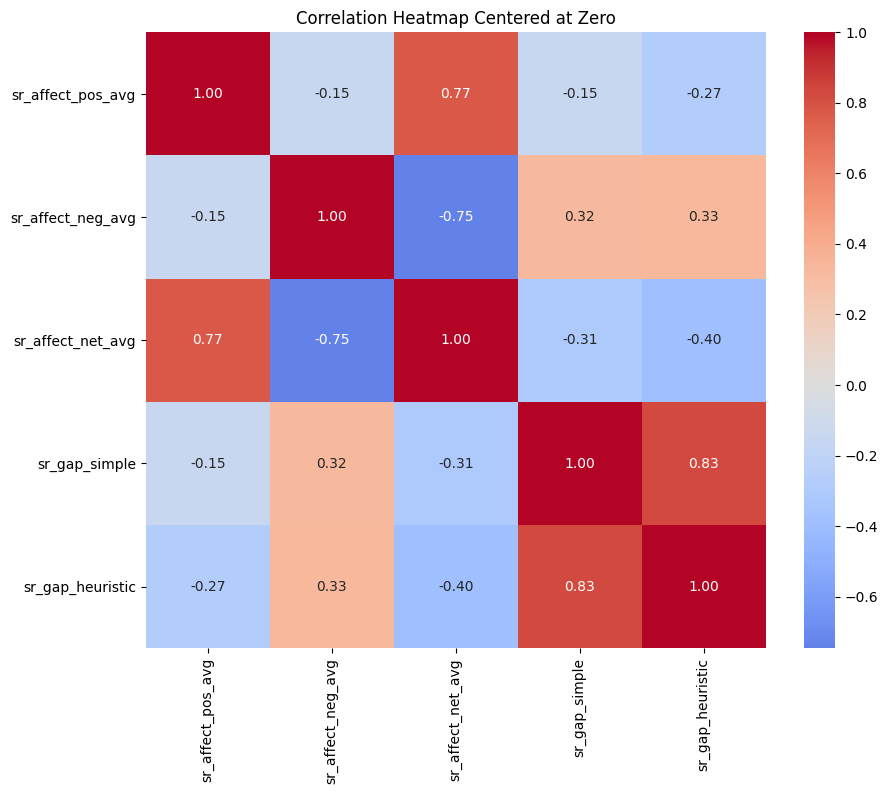

In [9]:
# Now, calculate the correlation between the specified columns
columns_of_interest = ['sr_affect_pos_avg', 'sr_affect_neg_avg', 'sr_affect_net_avg', 'sr_gap_simple', 'sr_gap_heuristic']
correlation_matrix = df[columns_of_interest].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap Centered at Zero')
plt.show()

In [11]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Check for missing values in the relevant columns
missing_values_check = df[['sr_affect_net_avg', 'sr_gap_heuristic', 'PID']].isnull().sum()

# If there are missing values, we'll drop rows with any missing values in these columns
if missing_values_check.sum() > 0:
    df_cleaned = df.dropna(subset=['sr_affect_net_avg', 'sr_gap_heuristic', 'PID'])
else:
    df_cleaned = df

# Attempt to fit the model again with the cleaned dataframe
try:
    mixed_lm_model_cleaned = smf.mixedlm('sr_affect_net_avg ~ sr_gap_heuristic', df_cleaned, groups=df_cleaned['PID'], re_formula='1+sr_gap_heuristic')
    mixed_lm_result_cleaned = mixed_lm_model_cleaned.fit()
    summary_cleaned = mixed_lm_result_cleaned.summary()
except Exception as e:
    summary_cleaned = str(e)

summary_cleaned

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                MixedLM   Dependent Variable:   sr_affect_net_avg
No. Observations:     7828      Method:               REML             
No. Groups:           105       Scale:                0.6337           
Min. group size:      40        Log-Likelihood:       -9639.4396       
Max. group size:      84        Converged:            Yes              
Mean group size:      74.6                                             
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.921    0.098  9.422 0.000  0.730  1.113
sr_gap_heuristic             -0.012    0.001 -9.764 0.000 -0.014 -0.009
Group Var                     0.917    0.174                           
Group x sr_gap_heuristic Cov -0.004    0.002                           
sr_gap_heuristic Var          0.000    0.000                           
=======================================================================

"""

### Mixed Effects Model Results

The mixed effects model predicting **sr_affect_net_avg** from **sr_gap_heuristic**, nested within **PID** with random slopes and intercepts for **sr_gap_heuristic**, yielded the following results:

- **Intercept**: The average **sr_affect_net_avg** when **sr_gap_heuristic** is 0 is estimated to be `0.921`, with a standard error of `0.098`. This intercept is statistically significant with a *p*-value < 0.001, indicating a strong evidence of the intercept's deviation from 0.

- **sr_gap_heuristic**: The coefficient for **sr_gap_heuristic** is `-0.012` with a standard error of `0.001`. This suggests a significant negative relationship with **sr_affect_net_avg**, with a *p*-value < 0.001. The interpretation is that, as **sr_gap_heuristic** increases by one unit, **sr_affect_net_avg** tends to decrease by 0.012 units, holding all else constant.

- **Random Effects**:
    - **Group Variance (Intercept)**: The variance of the random intercepts across groups (PID) is `0.917`, indicating variability in the baseline **sr_affect_net_avg** across individuals.
    - **Group x sr_gap_heuristic Covariance**: The covariance between the intercepts and slopes within groups is `-0.004`, suggesting a slight tendency for individuals with higher baseline scores to have a less negative (or more positive) slope for **sr_gap_heuristic**.
    - **sr_gap_heuristic Variance**: The variance of the random slopes for **sr_gap_heuristic** within groups is near zero, indicating minimal variability in the relationship between **sr_gap_heuristic** and **sr_affect_net_avg** across individuals.

The model convergence was successful, though it's noted that the maximum likelihood estimate (MLE) may be on the boundary of the parameter space. This typically implies that some of the variance components are estimated to be very close to zero, particularly for the **sr_gap_heuristic Variance**.

These findings illustrate the impact of heuristic gap scores on net affect averages while accounting for individual differences across participants.


In [12]:
# Normalized version
from sklearn.preprocessing import StandardScaler

# Normalizing the variables 'sr_affect_net_avg' and 'sr_gap_heuristic'
scaler = StandardScaler()
df_cleaned[['sr_affect_net_avg', 'sr_gap_heuristic']] = scaler.fit_transform(df_cleaned[['sr_affect_net_avg', 'sr_gap_heuristic']])

# Fit the mixed effects model again with the normalized variables
mixed_lm_model_normalized = smf.mixedlm('sr_affect_net_avg ~ sr_gap_heuristic', df_cleaned, groups=df_cleaned['PID'], re_formula='1+sr_gap_heuristic')
mixed_lm_result_normalized = mixed_lm_model_normalized.fit()

# Summary of the model with normalized variables
summary_normalized = mixed_lm_result_normalized.summary()
summary_normalized

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_97651/434656378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[['sr_affect_net_avg', 'sr_gap_heuristic']] = scaler.fit_transform(df_cleaned[['sr_affect_net_avg', 'sr_gap_heuristic']])


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                MixedLM   Dependent Variable:   sr_affect_net_avg
No. Observations:     7828      Method:               REML             
No. Groups:           105       Scale:                0.3781           
Min. group size:      40        Log-Likelihood:       -7615.5969       
Max. group size:      84        Converged:            Yes              
Mean group size:      74.6                                             
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    -0.007    0.067 -0.098 0.922 -0.138  0.125
sr_gap_heuristic             -0.184    0.019 -9.764 0.000 -0.221 -0.147
Group Var                     0.466    0.108                           
Group x sr_gap_heuristic Cov  0.008    0.021                           
sr_gap_heuristic Var          0.027    0.008                           
=======================================================================

"""

## All Passive Measures

In [62]:
[col for col in df.columns if 'sad' in col]

['affect_neg_sad',
 'affect_neg_sad_am',
 'passive_sk_keyboard_sentiment_emoji_sad',
 'passive_sk_keyboard_sentiment_word_sad']

In [69]:
df['passive_sk_keyboard_sentiment_emoji_sad'].value_counts()

passive_sk_keyboard_sentiment_emoji_sad
0.0      2811
1.0       504
2.0       347
3.0       288
4.0       247
         ... 
132.0       1
129.0       1
92.0        1
97.0        1
167.0       1
Name: count, Length: 122, dtype: int64

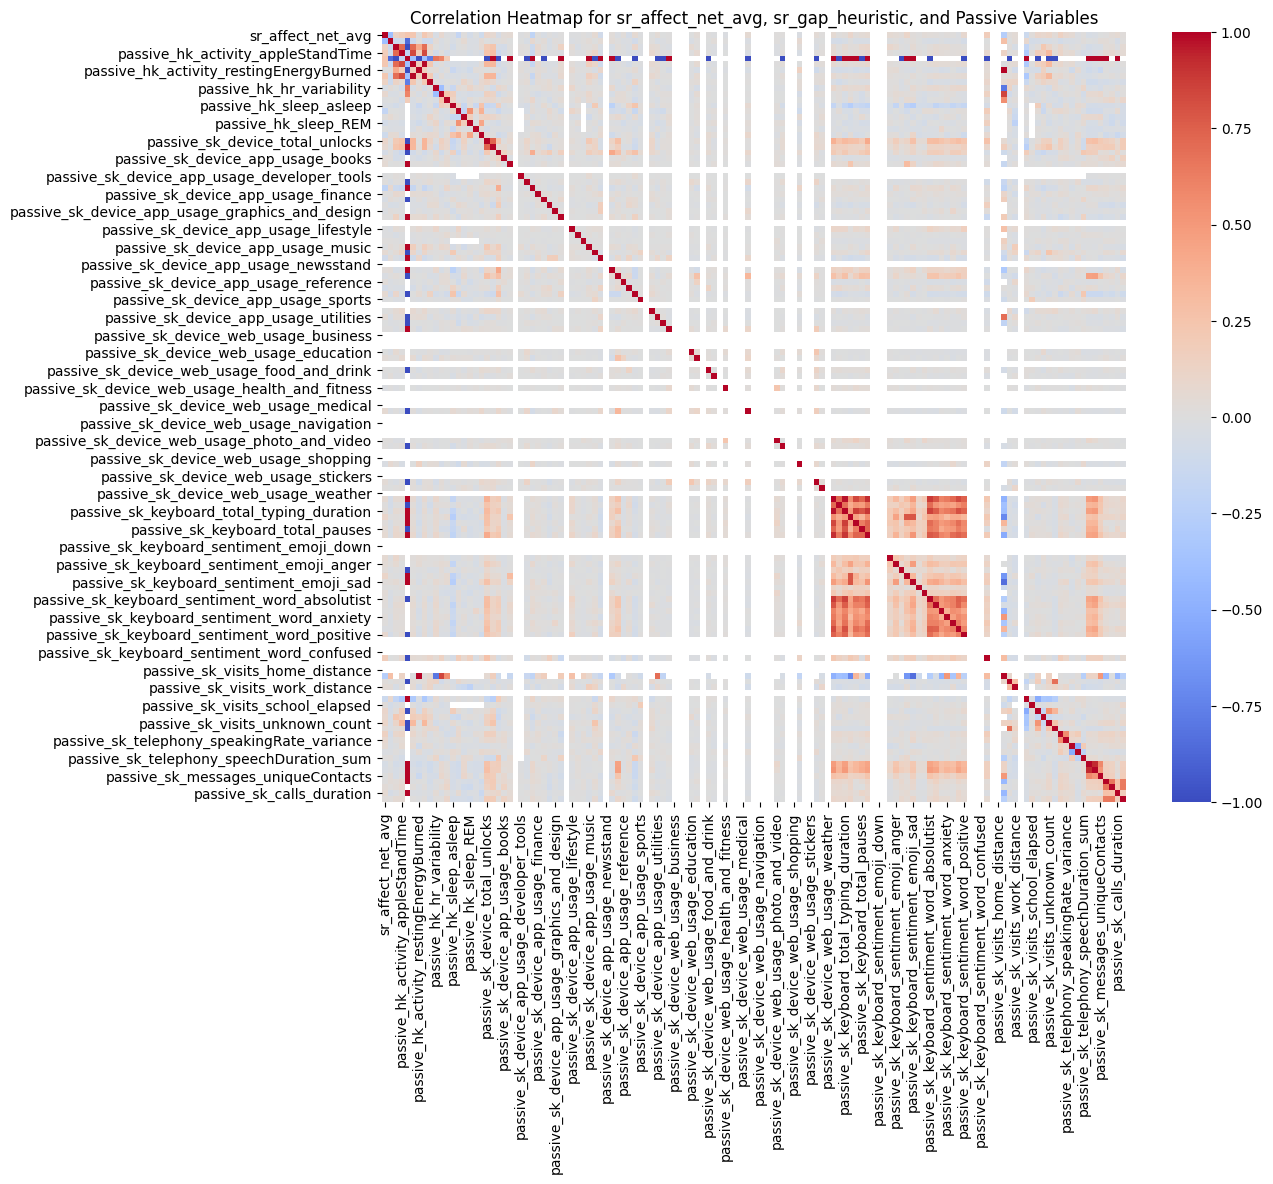

In [13]:
# Identifying columns that contain the string 'passive'
passive_columns = [col for col in df_cleaned.columns if 'passive' in col]

# Selecting the columns of interest for the correlation matrix
columns_for_correlation = ['sr_affect_net_avg', 'sr_gap_heuristic'] + passive_columns

# Calculating the correlation matrix for the selected columns
correlation_matrix_passive = df_cleaned[columns_for_correlation].corr()

# Creating a heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_passive, annot=False, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap for sr_affect_net_avg, sr_gap_heuristic, and Passive Variables')
plt.show()

### Top 10: Gap

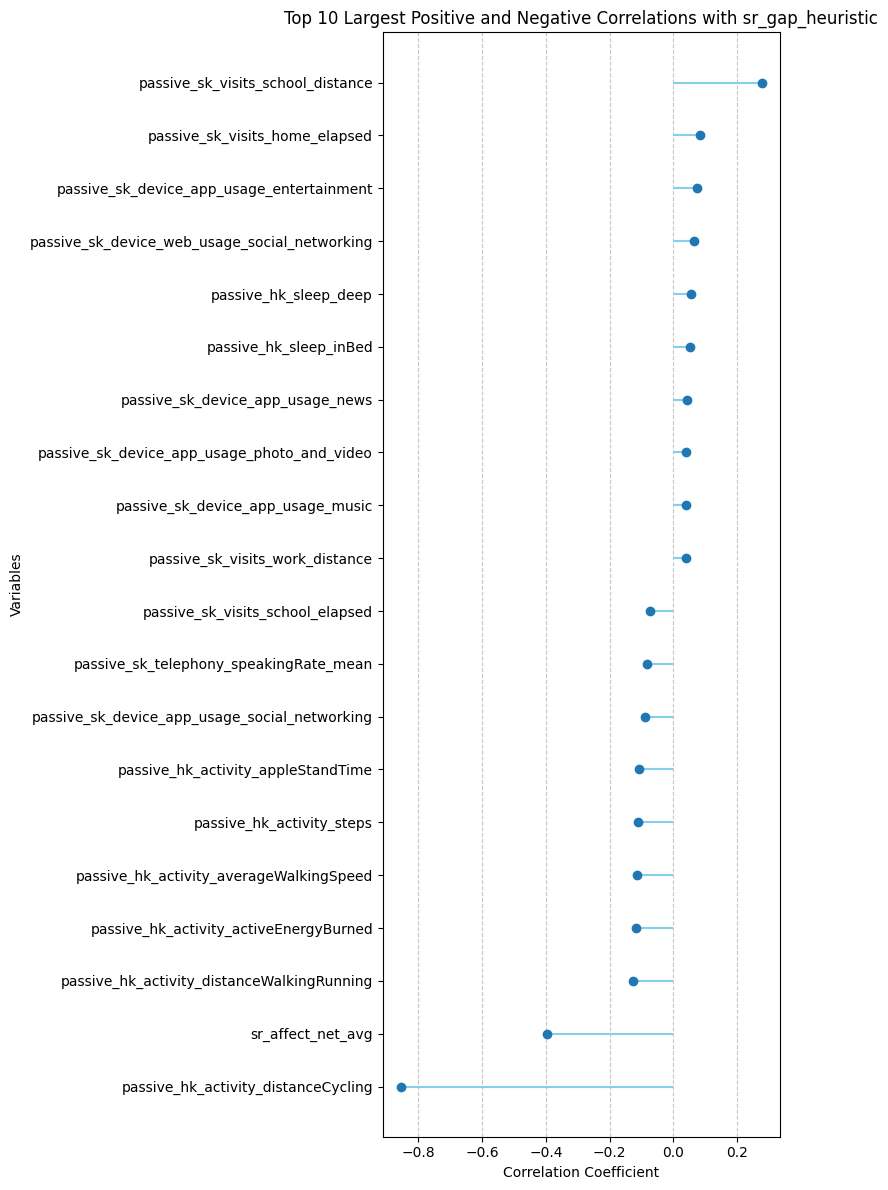

In [14]:
# Filter correlations specifically related to 'sr_gap_heuristic'
sr_gap_corr = correlation_matrix_passive.loc['sr_gap_heuristic'].reset_index()
sr_gap_corr.columns = ['Variable', 'Correlation']

# Remove the correlation of 'sr_gap_heuristic' with itself
sr_gap_corr_filtered = sr_gap_corr[sr_gap_corr['Variable'] != 'sr_gap_heuristic']

# Sort by absolute correlation to find the largest positive and negative correlations with 'sr_gap_heuristic'
sr_gap_corr_sorted = sr_gap_corr_filtered.copy()
sr_gap_corr_sorted['AbsCorrelation'] = sr_gap_corr_sorted['Correlation'].abs()
sr_gap_corr_sorted = sr_gap_corr_sorted.sort_values(by='AbsCorrelation', ascending=False)

# Select the 10 largest positive and 10 largest negative correlations
top_pos_corr_gap = sr_gap_corr_sorted[sr_gap_corr_sorted['Correlation'] > 0].head(10)
top_neg_corr_gap = sr_gap_corr_sorted[sr_gap_corr_sorted['Correlation'] < 0].head(10)

# Combine the top positive and negative correlations
top_correlations_gap = pd.concat([top_pos_corr_gap, top_neg_corr_gap])

# Sorting the combined top correlations with 'sr_gap_heuristic' from most positive to most negative for a vertical plot
top_correlations_gap_sorted = top_correlations_gap.sort_values(by='Correlation', ascending=True)

# Plotting the vertical lollipop plot
plt.figure(figsize=(8, 12))
plt.hlines(y=top_correlations_gap_sorted['Variable'], xmin=0, xmax=top_correlations_gap_sorted['Correlation'], color='skyblue')
plt.plot(top_correlations_gap_sorted['Correlation'], top_correlations_gap_sorted['Variable'], "o")
plt.title('Top 10 Largest Positive and Negative Correlations with sr_gap_heuristic')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Top 10: Affect

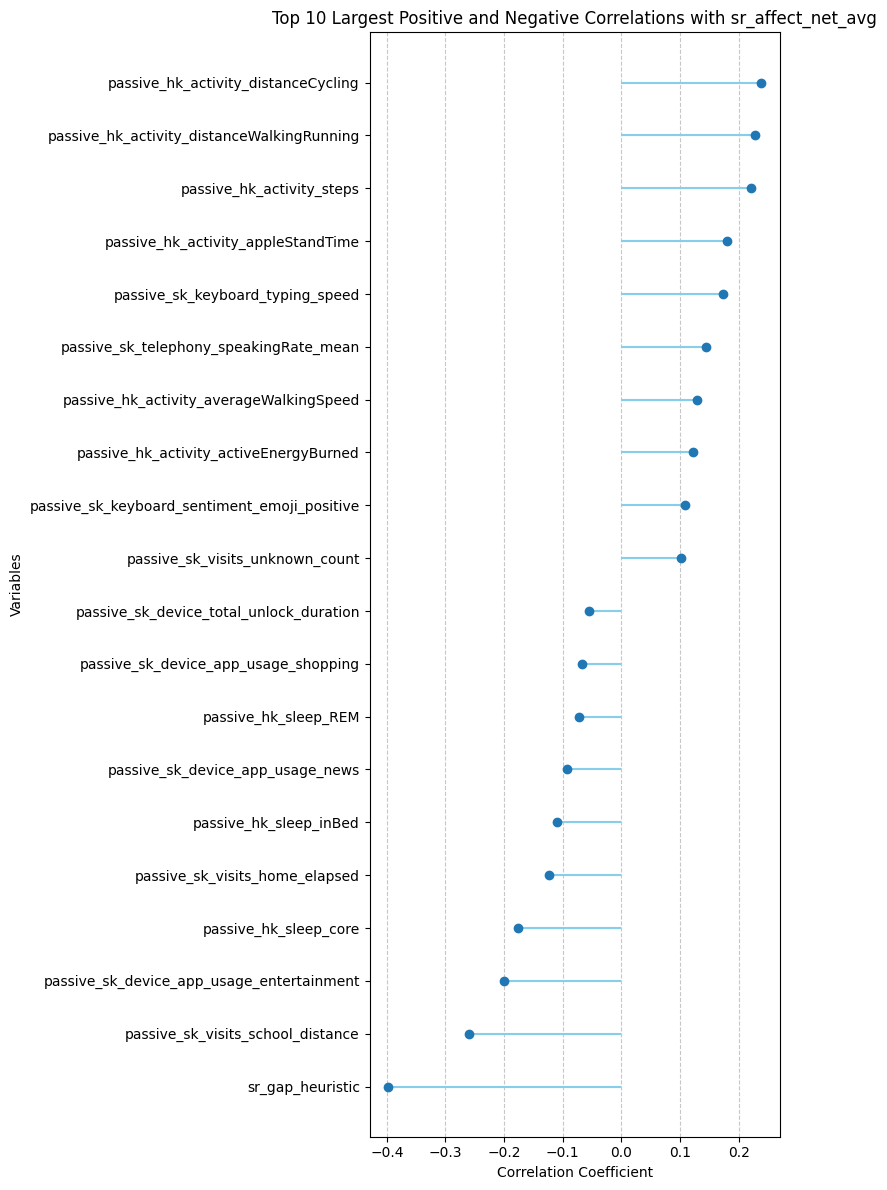

In [15]:
# Filter correlations specifically related to 'sr_affect_net_avg'
sr_gap_corr = correlation_matrix_passive.loc['sr_affect_net_avg'].reset_index()
sr_gap_corr.columns = ['Variable', 'Correlation']

# Remove the correlation of 'sr_affect_net_avg' with itself
sr_gap_corr_filtered = sr_gap_corr[sr_gap_corr['Variable'] != 'sr_affect_net_avg']

# Sort by absolute correlation to find the largest positive and negative correlations with 'sr_affect_net_avg'
sr_gap_corr_sorted = sr_gap_corr_filtered.copy()
sr_gap_corr_sorted['AbsCorrelation'] = sr_gap_corr_sorted['Correlation'].abs()
sr_gap_corr_sorted = sr_gap_corr_sorted.sort_values(by='AbsCorrelation', ascending=False)

# Select the 10 largest positive and 10 largest negative correlations
top_pos_corr_gap = sr_gap_corr_sorted[sr_gap_corr_sorted['Correlation'] > 0].head(10)
top_neg_corr_gap = sr_gap_corr_sorted[sr_gap_corr_sorted['Correlation'] < 0].head(10)

# Combine the top positive and negative correlations
top_correlations_gap = pd.concat([top_pos_corr_gap, top_neg_corr_gap])

# Sorting the combined top correlations with 'sr_affect_net_avg' from most positive to most negative for a vertical plot
top_correlations_gap_sorted = top_correlations_gap.sort_values(by='Correlation', ascending=True)

# Plotting the vertical lollipop plot
plt.figure(figsize=(8, 12))
plt.hlines(y=top_correlations_gap_sorted['Variable'], xmin=0, xmax=top_correlations_gap_sorted['Correlation'], color='skyblue')
plt.plot(top_correlations_gap_sorted['Correlation'], top_correlations_gap_sorted['Variable'], "o")
plt.title('Top 10 Largest Positive and Negative Correlations with sr_affect_net_avg')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Activity

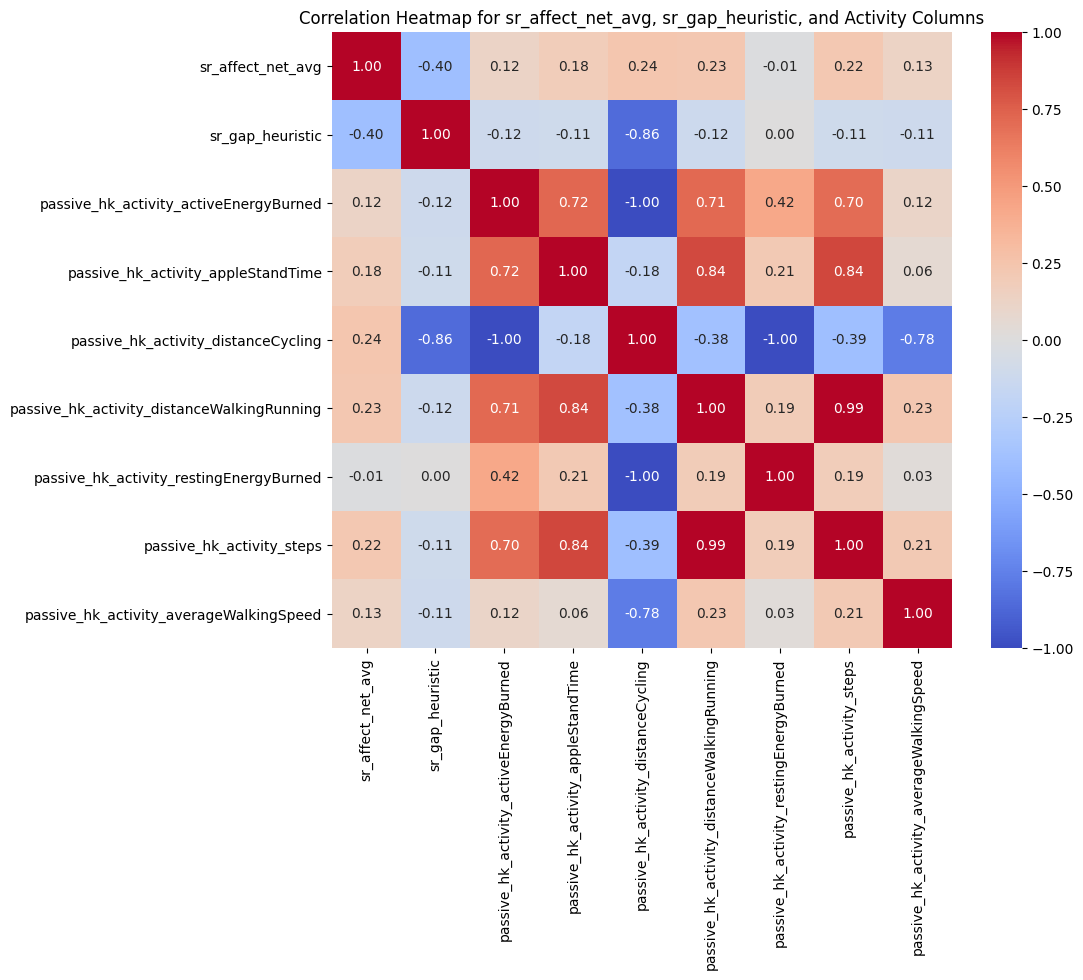

In [16]:
# Filter columns containing the string 'activity'
activity_columns = df.columns[df.columns.str.contains('activity')]

# Select relevant columns for the new correlation matrix
columns_for_new_correlation = ['sr_affect_net_avg', 'sr_gap_heuristic'] + activity_columns.tolist()

# Calculate new correlation matrix
new_correlation_matrix = df[columns_for_new_correlation].corr()

# Plot new correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap for sr_affect_net_avg, sr_gap_heuristic, and Activity Columns')
plt.show()


In [17]:
df.passive_hk_activity_activeEnergyBurned.notna().sum()

4622

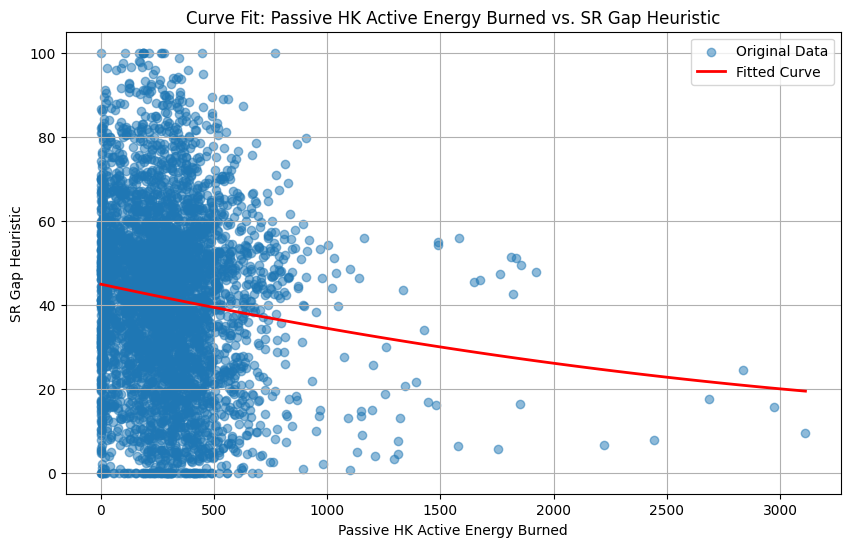

array([ 1.10650347e-06, -1.16254052e-02,  4.48891295e+01])

In [30]:
# Prepare data, removing NaN values
df_nonan_energy_gap = df.dropna(subset=['passive_hk_activity_activeEnergyBurned', 'sr_gap_heuristic'])
x_data_energy = df_nonan_energy_gap['passive_hk_activity_activeEnergyBurned']
y_data_gap = df_nonan_energy_gap['sr_gap_heuristic']

# Fit the curve (using a polynomial of second degree)
params_energy_gap, cov_energy_gap = curve_fit(poly2, x_data_energy, y_data_gap)

# Generate x values for the curve
x_fit_energy = np.linspace(x_data_energy.min(), x_data_energy.max(), 100)
# Calculate y values for the curve
y_fit_gap = poly2(x_fit_energy, *params_energy_gap)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data_energy, y_data_gap, alpha=0.5, label='Original Data')
plt.plot(x_fit_energy, y_fit_gap, color='red', linewidth=2, label='Fitted Curve')
plt.title('Curve Fit: Passive HK Active Energy Burned vs. SR Gap Heuristic')
plt.xlabel('Passive HK Active Energy Burned')
plt.ylabel('SR Gap Heuristic')
plt.legend()
plt.grid(True)
plt.show()

params_energy_gap

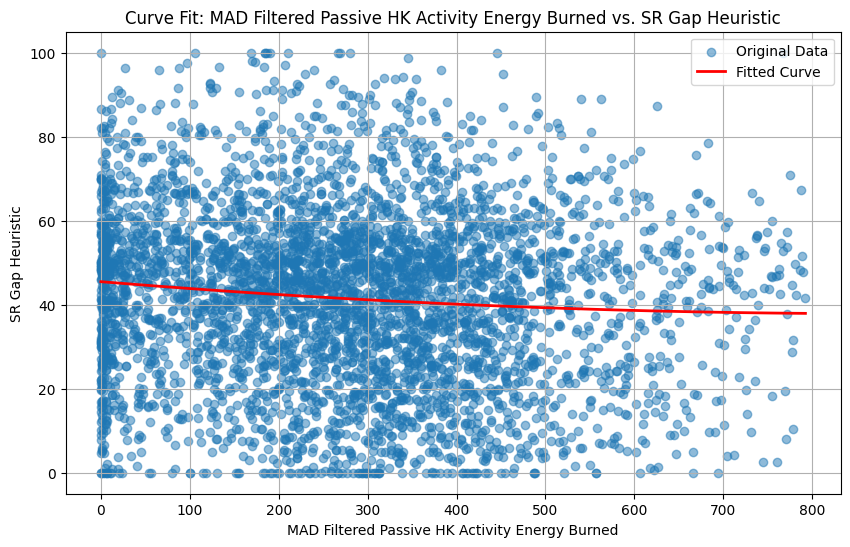

array([ 9.83923296e-06, -1.73208130e-02,  4.54891772e+01])

In [32]:
# Calculate the Median Absolute Deviation (MAD) for 'passive_hk_activity_activeEnergyBurned'
median_energy = df['passive_hk_activity_activeEnergyBurned'].median()
mad_energy = abs(df['passive_hk_activity_activeEnergyBurned'] - median_energy).median()

# Define a threshold for outliers based on MAD (commonly, 3 * MAD from the median is used)
threshold = 4 * mad_energy

# Filter out outliers based on MAD
df_filtered_mad = df[
    (df['passive_hk_activity_activeEnergyBurned'] > (median_energy - threshold)) &
    (df['passive_hk_activity_activeEnergyBurned'] < (median_energy + threshold))
]

# Prepare data for scatterplot and curve fit, removing NaN values
df_nonan_energy_filtered_mad = df_filtered_mad.dropna(subset=['passive_hk_activity_activeEnergyBurned', 'sr_gap_heuristic'])
x_data_energy_filtered_mad = df_nonan_energy_filtered_mad['passive_hk_activity_activeEnergyBurned']
y_data_gap_filtered_mad = df_nonan_energy_filtered_mad['sr_gap_heuristic']

# Fit the curve (using a polynomial of second degree)
params_energy_gap_filtered_mad, cov_energy_gap_filtered_mad = curve_fit(poly2, x_data_energy_filtered_mad, y_data_gap_filtered_mad)

# Generate x values for the curve
x_fit_energy_filtered_mad = np.linspace(x_data_energy_filtered_mad.min(), x_data_energy_filtered_mad.max(), 100)
# Calculate y values for the curve
y_fit_gap_filtered_mad = poly2(x_fit_energy_filtered_mad, *params_energy_gap_filtered_mad)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data_energy_filtered_mad, y_data_gap_filtered_mad, alpha=0.5, label='Original Data')
plt.plot(x_fit_energy_filtered_mad, y_fit_gap_filtered_mad, color='red', linewidth=2, label='Fitted Curve')
plt.title('Curve Fit: MAD Filtered Passive HK Activity Energy Burned vs. SR Gap Heuristic')
plt.xlabel('MAD Filtered Passive HK Activity Energy Burned')
plt.ylabel('SR Gap Heuristic')
plt.legend()
plt.grid(True)
plt.show()

params_energy_gap_filtered_mad


## Sleep

In [18]:
# all sleep measure
df['passive_hk_all_sleep'] = df['passive_hk_sleep_REM'] + df['passive_hk_sleep_deep'] + df['passive_hk_sleep_core']

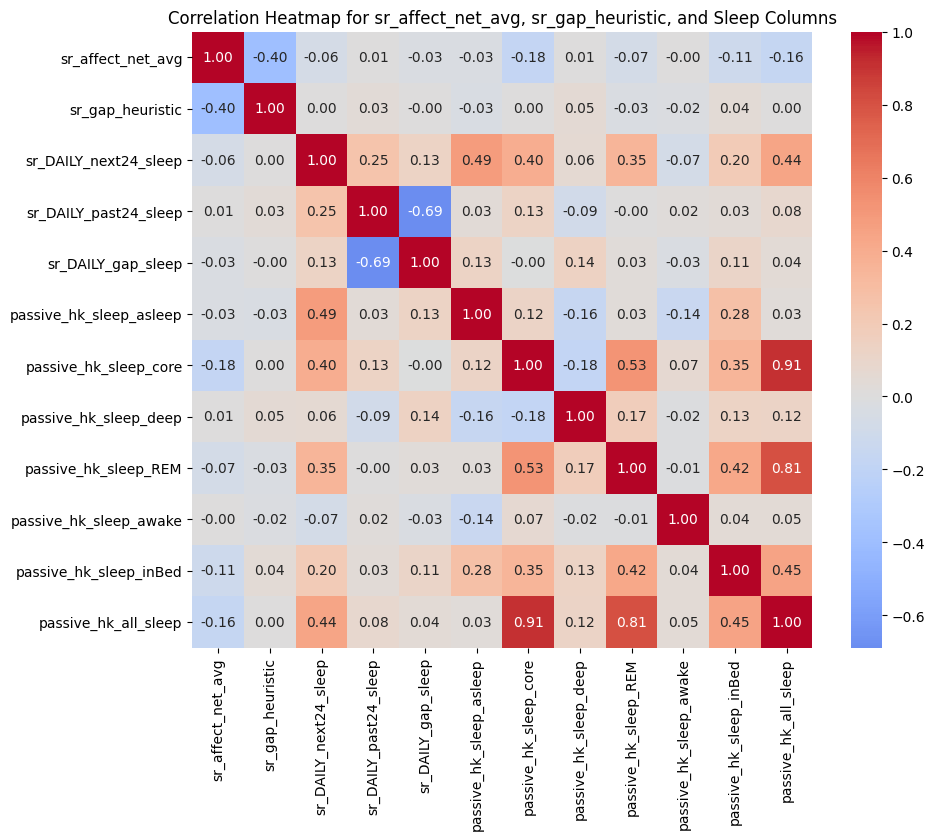

In [19]:
# Filter columns containing the string 'sleep'
sleep_columns = df.columns[df.columns.str.contains('sleep')]

# Select relevant columns for the new correlation matrix
columns_for_new_correlation = ['sr_affect_net_avg', 'sr_gap_heuristic'] + sleep_columns.tolist()

# Calculate new correlation matrix
new_correlation_matrix = df[columns_for_new_correlation].corr()

# Plot new correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap for sr_affect_net_avg, sr_gap_heuristic, and Sleep Columns')
plt.show()

### Passive vs. Active Sleep Data

Does previous day's sleep correlate with report of `sr_DAILY_past24_sleep`?

In [20]:
import statsmodels.formula.api as smf

# Shift the 'passive_hk_all_sleep' column to get the previous day's value for each PID
df['prev_passive_hk_all_sleep'] = df.groupby('PID')['passive_hk_all_sleep'].shift(1)

# Remove rows with missing values in either the target or the predictor to ensure a clean dataset for modeling
df_model = df.dropna(subset=['sr_DAILY_past24_sleep', 'prev_passive_hk_all_sleep'])

# Define and fit the mixed effects model
mixed_effects_model = smf.mixedlm("sr_DAILY_past24_sleep ~ prev_passive_hk_all_sleep", df_model, groups=df_model["PID"])
mixed_effects_model_result = mixed_effects_model.fit()

# Print the model summary
mixed_effects_model_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: sr_DAILY_past24_sleep
No. Observations: 1960    Method:             REML                 
No. Groups:       46      Scale:              1.1259               
Min. group size:  1       Log-Likelihood:     -2967.2136           
Max. group size:  80      Converged:          Yes                  
Mean group size:  42.6                                             
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 2.743    0.157 17.448 0.000  2.435  3.052
prev_passive_hk_all_sleep 0.011    0.000 37.234 0.000  0.010  0.012
Group Var                 0.453    0.102                           
===================================================================

"""

In [21]:
# First, we identify and exclude groups (PIDs) with less than 10 observations
group_counts = df_model['PID'].value_counts()
groups_to_keep = group_counts[group_counts >= 10].index

# Filter the dataset to include only the groups with >= 10 observations
df_model_filtered = df_model[df_model['PID'].isin(groups_to_keep)]

# Define and fit the adjusted mixed effects model on the filtered dataset
adjusted_mixed_effects_model = smf.mixedlm("sr_DAILY_past24_sleep ~ prev_passive_hk_all_sleep", df_model_filtered, groups=df_model_filtered["PID"])
adjusted_mixed_effects_model_result = adjusted_mixed_effects_model.fit()

# Print the model summary for the adjusted model
adjusted_mixed_effects_model_result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: sr_DAILY_past24_sleep
No. Observations: 1951    Method:             REML                 
No. Groups:       44      Scale:              1.1060               
Min. group size:  10      Log-Likelihood:     -2934.5289           
Max. group size:  80      Converged:          Yes                  
Mean group size:  44.3                                             
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 2.718    0.155 17.527 0.000  2.414  3.022
prev_passive_hk_all_sleep 0.011    0.000 37.519 0.000  0.010  0.012
Group Var                 0.421    0.095                           
===================================================================

"""

**Coefficients**:

- **Intercept (2.718)**: The estimated average self-reported sleep when the previous day's passive total sleep is zero. This value is slightly lower than in the previous model but remains significantly different from zero.

- **`prev_passive_hk_all_sleep` (0.011)**: The estimated increase in self-reported sleep for each unit increase in the previous day's passive sleep remains consistent and highly significant.
    - This coefficient suggests that for every additional unit (minute) of sleep recorded by the passive sensor on the previous day, the current day's self-reported sleep duration increases by 0.011 hours (or approximately 0.66 minutes), with a standard error of 0.000.
- **Group Var (0.421)**: The variance attributed to the random effects decreased slightly, suggesting less variability in self-reported sleep across individuals in the filtered dataset.

### Rolling Average Sleep

In [22]:
# Calculate the 3, 5, and 7 day rolling averages for each PID for both 'sr_DAILY_past24_sleep' and 'passive_hk_all_sleep'
rolling_windows = [3, 5, 7]

for window in rolling_windows:
    df[f'sr_DAILY_past24_sleep_{window}d_rolling'] = df.groupby('PID')['sr_DAILY_past24_sleep'].transform(lambda x: x.rolling(window=window).mean())
    df[f'passive_hk_all_sleep_{window}d_rolling'] = df.groupby('PID')['passive_hk_all_sleep'].transform(lambda x: x.rolling(window=window).mean())

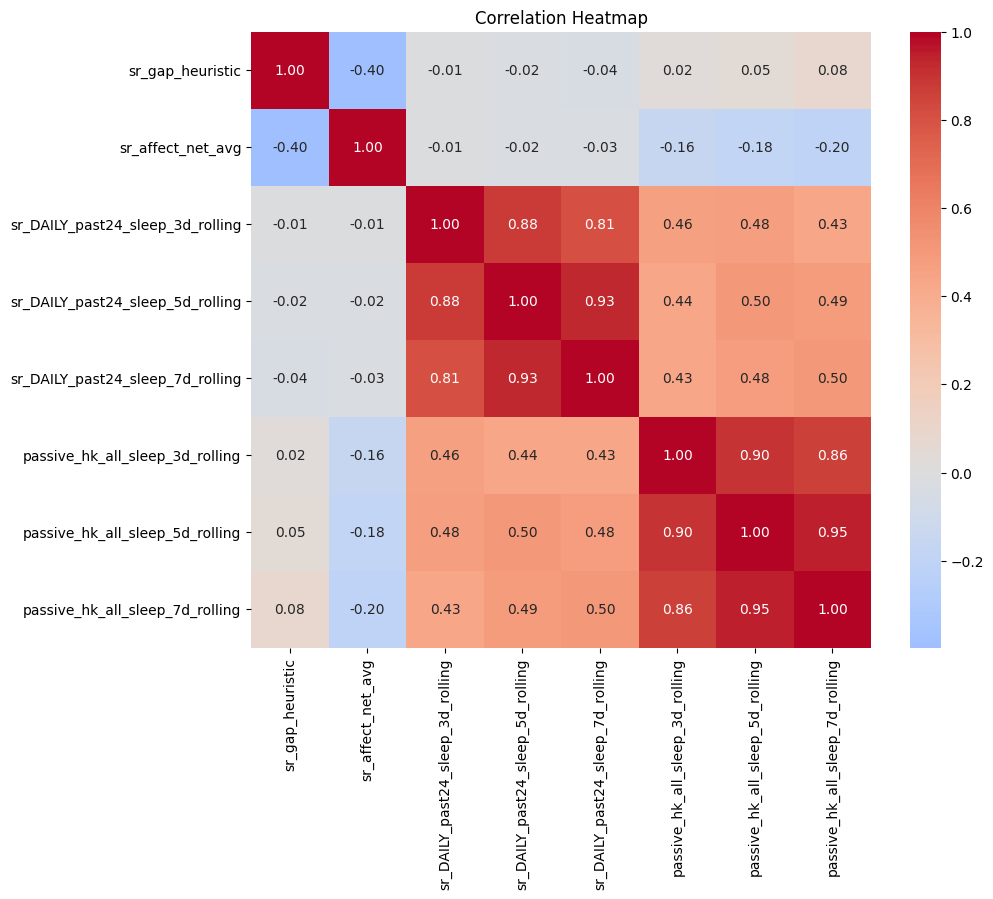

In [23]:
# Select the columns for the correlation table
columns_for_correlation_table = ['sr_gap_heuristic', 'sr_affect_net_avg'] + [f'sr_DAILY_past24_sleep_{window}d_rolling' for window in rolling_windows] + [f'passive_hk_all_sleep_{window}d_rolling' for window in rolling_windows]

# Calculate the correlation matrix for the selected columns
correlation_table = df[columns_for_correlation_table].corr()

# Plot the correlation table as a heatmap with color gradient centered at 0
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

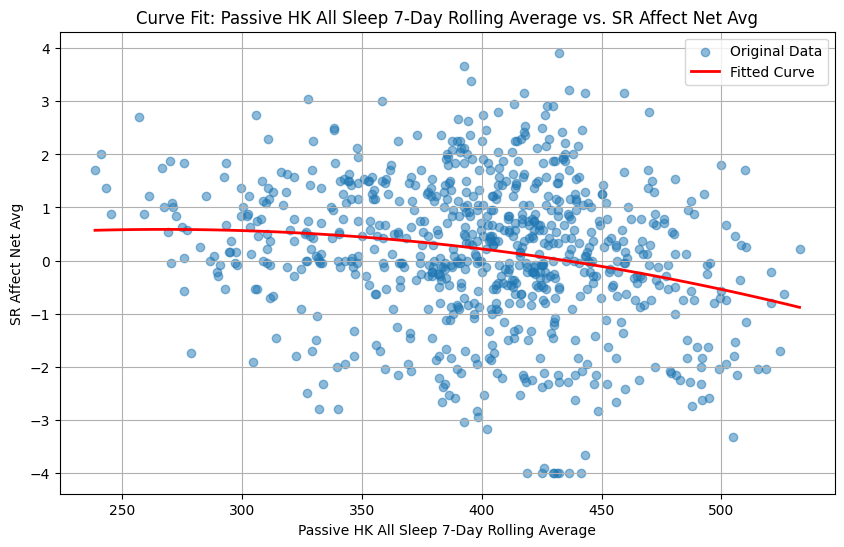

array([-2.08401468e-05,  1.11342776e-02, -9.00759186e-01])

In [24]:
from scipy.optimize import curve_fit
import numpy as np

# Define a function for curve fitting, e.g., a polynomial of second degree for simplicity
def poly2(x, a, b, c):
    return a * x**2 + b * x + c

# Prepare data, removing NaN values
df_nonan = df.dropna(subset=['passive_hk_all_sleep_7d_rolling', 'sr_affect_net_avg'])
x_data = df_nonan['passive_hk_all_sleep_7d_rolling']
y_data = df_nonan['sr_affect_net_avg']

# Fit the curve
params, cov = curve_fit(poly2, x_data, y_data)

# Generate x values for the curve
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
# Calculate y values for the curve
y_fit = poly2(x_fit, *params)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5, label='Original Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted Curve')
plt.title('Curve Fit: Passive HK All Sleep 7-Day Rolling Average vs. SR Affect Net Avg')
plt.xlabel('Passive HK All Sleep 7-Day Rolling Average')
plt.ylabel('SR Affect Net Avg')
plt.legend()
plt.grid(True)
plt.show()

params


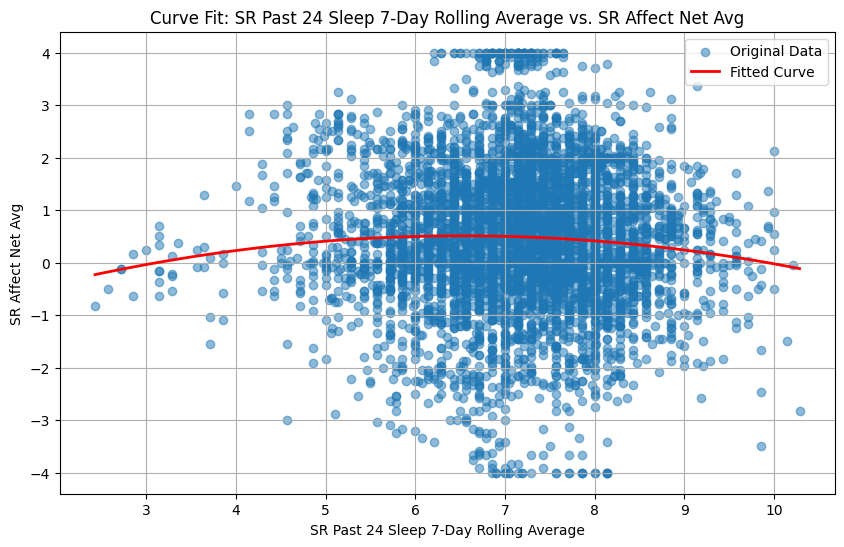

array([-0.0441065 ,  0.57546509, -1.36454672])

In [25]:
from scipy.optimize import curve_fit
import numpy as np

# Define a function for curve fitting, e.g., a polynomial of second degree for simplicity
def poly2(x, a, b, c):
    return a * x**2 + b * x + c

# Prepare data, removing NaN values
df_nonan = df.dropna(subset=['sr_DAILY_past24_sleep_7d_rolling', 'sr_affect_net_avg'])
x_data = df_nonan['sr_DAILY_past24_sleep_7d_rolling']
y_data = df_nonan['sr_affect_net_avg']

# Fit the curve
params, cov = curve_fit(poly2, x_data, y_data)

# Generate x values for the curve
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
# Calculate y values for the curve
y_fit = poly2(x_fit, *params)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5, label='Original Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted Curve')
plt.title('Curve Fit: SR Past 24 Sleep 7-Day Rolling Average vs. SR Affect Net Avg')
plt.xlabel('SR Past 24 Sleep 7-Day Rolling Average')
plt.ylabel('SR Affect Net Avg')
plt.legend()
plt.grid(True)
plt.show()

params


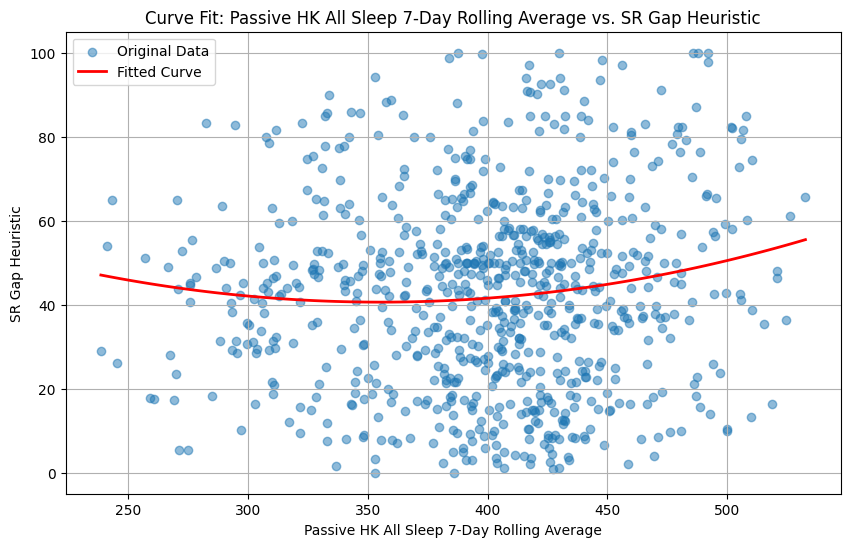

array([ 4.73560850e-04, -3.36594319e-01,  1.00426063e+02])

In [26]:
from scipy.optimize import curve_fit
import numpy as np

# Define a function for curve fitting, e.g., a polynomial of second degree for simplicity
def poly2(x, a, b, c):
    return a * x**2 + b * x + c

# Prepare data, removing NaN values
df_nonan = df.dropna(subset=['passive_hk_all_sleep_7d_rolling', 'sr_gap_heuristic'])
x_data = df_nonan['passive_hk_all_sleep_7d_rolling']
y_data = df_nonan['sr_gap_heuristic']

# Fit the curve
params, cov = curve_fit(poly2, x_data, y_data)

# Generate x values for the curve
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
# Calculate y values for the curve
y_fit = poly2(x_fit, *params)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5, label='Original Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted Curve')
plt.title('Curve Fit: Passive HK All Sleep 7-Day Rolling Average vs. SR Gap Heuristic')
plt.xlabel('Passive HK All Sleep 7-Day Rolling Average')
plt.ylabel('SR Gap Heuristic')
plt.legend()
plt.grid(True)
plt.show()

params


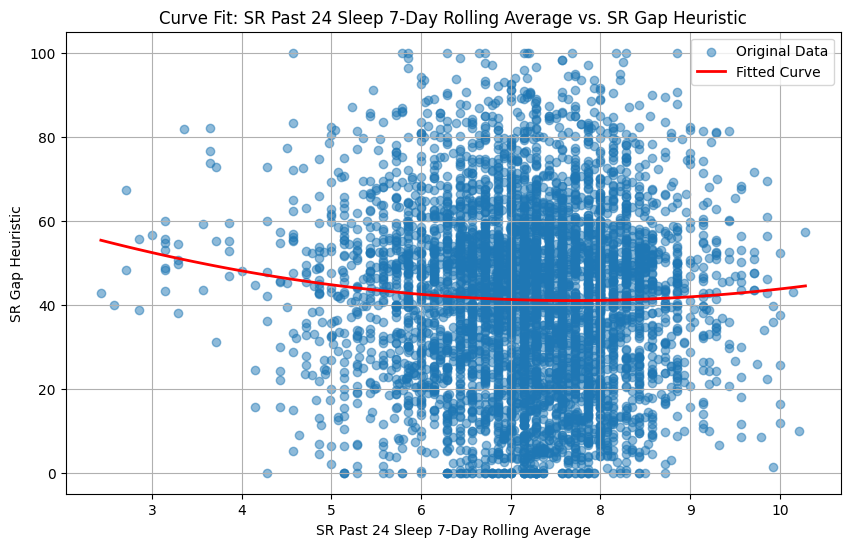

array([ 0.51866596, -7.97888467, 71.67442099])

In [27]:
from scipy.optimize import curve_fit
import numpy as np

# Define a function for curve fitting, e.g., a polynomial of second degree for simplicity
def poly2(x, a, b, c):
    return a * x**2 + b * x + c

# Prepare data, removing NaN values
df_nonan = df.dropna(subset=['sr_DAILY_past24_sleep_7d_rolling', 'sr_gap_heuristic'])
x_data = df_nonan['sr_DAILY_past24_sleep_7d_rolling']
y_data = df_nonan['sr_gap_heuristic']

# Fit the curve
params, cov = curve_fit(poly2, x_data, y_data)

# Generate x values for the curve
x_fit = np.linspace(x_data.min(), x_data.max(), 100)
# Calculate y values for the curve
y_fit = poly2(x_fit, *params)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5, label='Original Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted Curve')
plt.title('Curve Fit: SR Past 24 Sleep 7-Day Rolling Average vs. SR Gap Heuristic')
plt.xlabel('SR Past 24 Sleep 7-Day Rolling Average')
plt.ylabel('SR Gap Heuristic')
plt.legend()
plt.grid(True)
plt.show()

params


### Sleep Variability

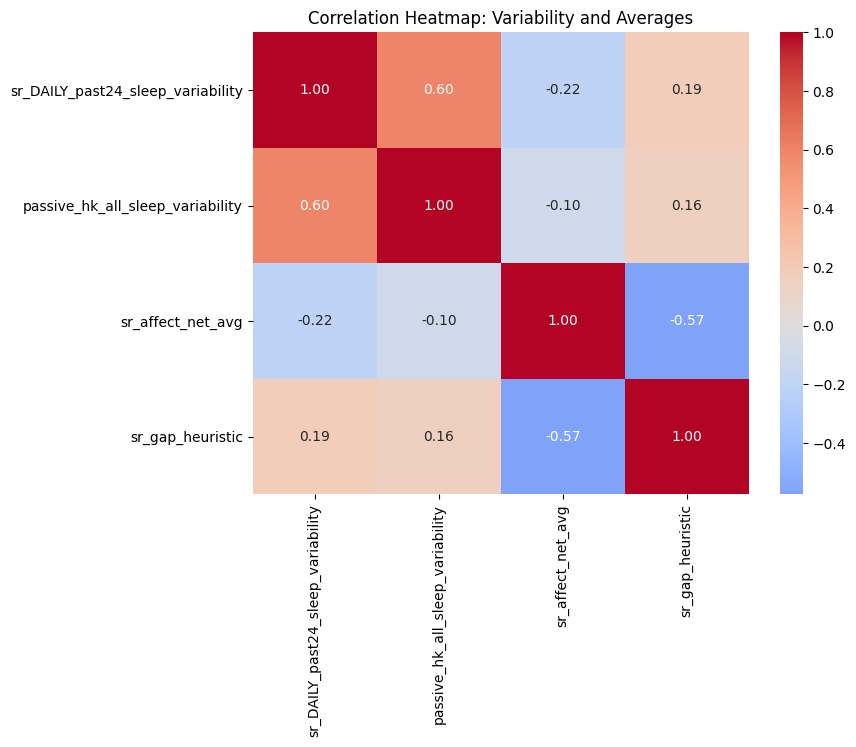

In [28]:
# Calculate the variability (standard deviation) for each PID for 'sr_DAILY_past24_sleep' and 'passive_hk_all_sleep'
variability_df = df.groupby('PID').agg({
    'sr_DAILY_past24_sleep': ['std', 'mean'],
    'passive_hk_all_sleep': ['std', 'mean'],
    'sr_affect_net_avg': 'mean',
    'sr_gap_heuristic': 'mean'
}).reset_index()

# Flatten the MultiIndex columns
variability_df.columns = ['_'.join(col).strip('_') for col in variability_df.columns.values]

# Rename the columns for clarity
variability_df.rename(columns={
    'sr_DAILY_past24_sleep_std': 'sr_DAILY_past24_sleep_variability',
    'sr_DAILY_past24_sleep_mean': 'sr_DAILY_past24_sleep_avg',
    'passive_hk_all_sleep_std': 'passive_hk_all_sleep_variability',
    'passive_hk_all_sleep_mean': 'passive_hk_all_sleep_avg',
    'sr_affect_net_avg_mean': 'sr_affect_net_avg',
    'sr_gap_heuristic_mean': 'sr_gap_heuristic'
}, inplace=True)

# Calculate the correlation of these variability and average values with each PID's average 'sr_affect_net_avg' and 'sr_gap_heuristic'
correlation_matrix_variability = variability_df[['sr_DAILY_past24_sleep_variability', 'passive_hk_all_sleep_variability', 'sr_affect_net_avg', 'sr_gap_heuristic']].corr()

# Plot the correlation heatmap for the variability and average values with gradient centered at 0
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_variability, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap: Variability and Averages')
plt.show()

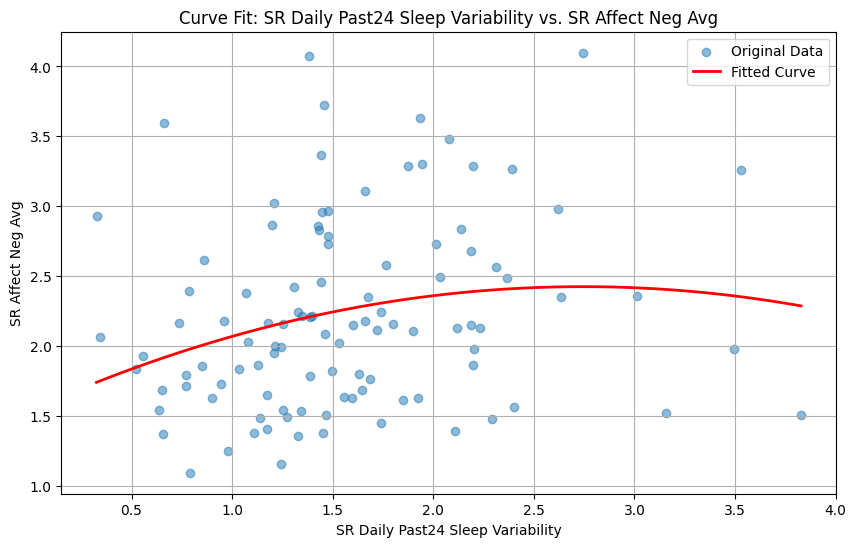

array([-0.11708031,  0.64252276,  1.54243155])

In [29]:
# Calculate the average of sr_affect_neg for each PID as sr_affect_neg_avg
variability_df['sr_affect_neg_avg'] = df.groupby('PID')['sr_affect_neg_avg'].mean().values

# Prepare data for scatterplot and curve fit, removing NaN values
df_nonan_variability = variability_df.dropna(subset=['sr_DAILY_past24_sleep_variability', 'sr_affect_neg_avg'])
x_data_variability = df_nonan_variability['sr_DAILY_past24_sleep_variability']
y_data_neg_avg = df_nonan_variability['sr_affect_neg_avg']

# Fit the curve (using a polynomial of second degree as before)
params_variability, cov_variability = curve_fit(poly2, x_data_variability, y_data_neg_avg)

# Generate x values for the curve
x_fit_variability = np.linspace(x_data_variability.min(), x_data_variability.max(), 100)
# Calculate y values for the curve
y_fit_neg_avg = poly2(x_fit_variability, *params_variability)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x_data_variability, y_data_neg_avg, alpha=0.5, label='Original Data')
plt.plot(x_fit_variability, y_fit_neg_avg, color='red', linewidth=2, label='Fitted Curve')
plt.title('Curve Fit: SR Daily Past24 Sleep Variability vs. SR Affect Neg Avg')
plt.xlabel('SR Daily Past24 Sleep Variability')
plt.ylabel('SR Affect Neg Avg')
plt.legend()
plt.grid(True)
plt.show()

params_variability


## Social Media

In [ ]:
# all sleep measure
df['passive_hk_all_sleep'] = df['passive_hk_sleep_REM'] + df['passive_hk_sleep_deep'] + df['passive_hk_sleep_core']

In [33]:
[col for col in df.columns if 'social' in col.lower()]

['sr_DAILY_next24_socialMedia',
 'sr_DAILY_past24_socialMedia',
 'sr_DAILY_gap_socialMedia',
 'passive_sk_device_app_usage_social_networking',
 'passive_sk_device_web_usage_social_networking']

In [40]:
df['passive_sk_social_total'] = df['passive_sk_device_app_usage_social_networking'] + df['passive_sk_device_web_usage_social_networking']

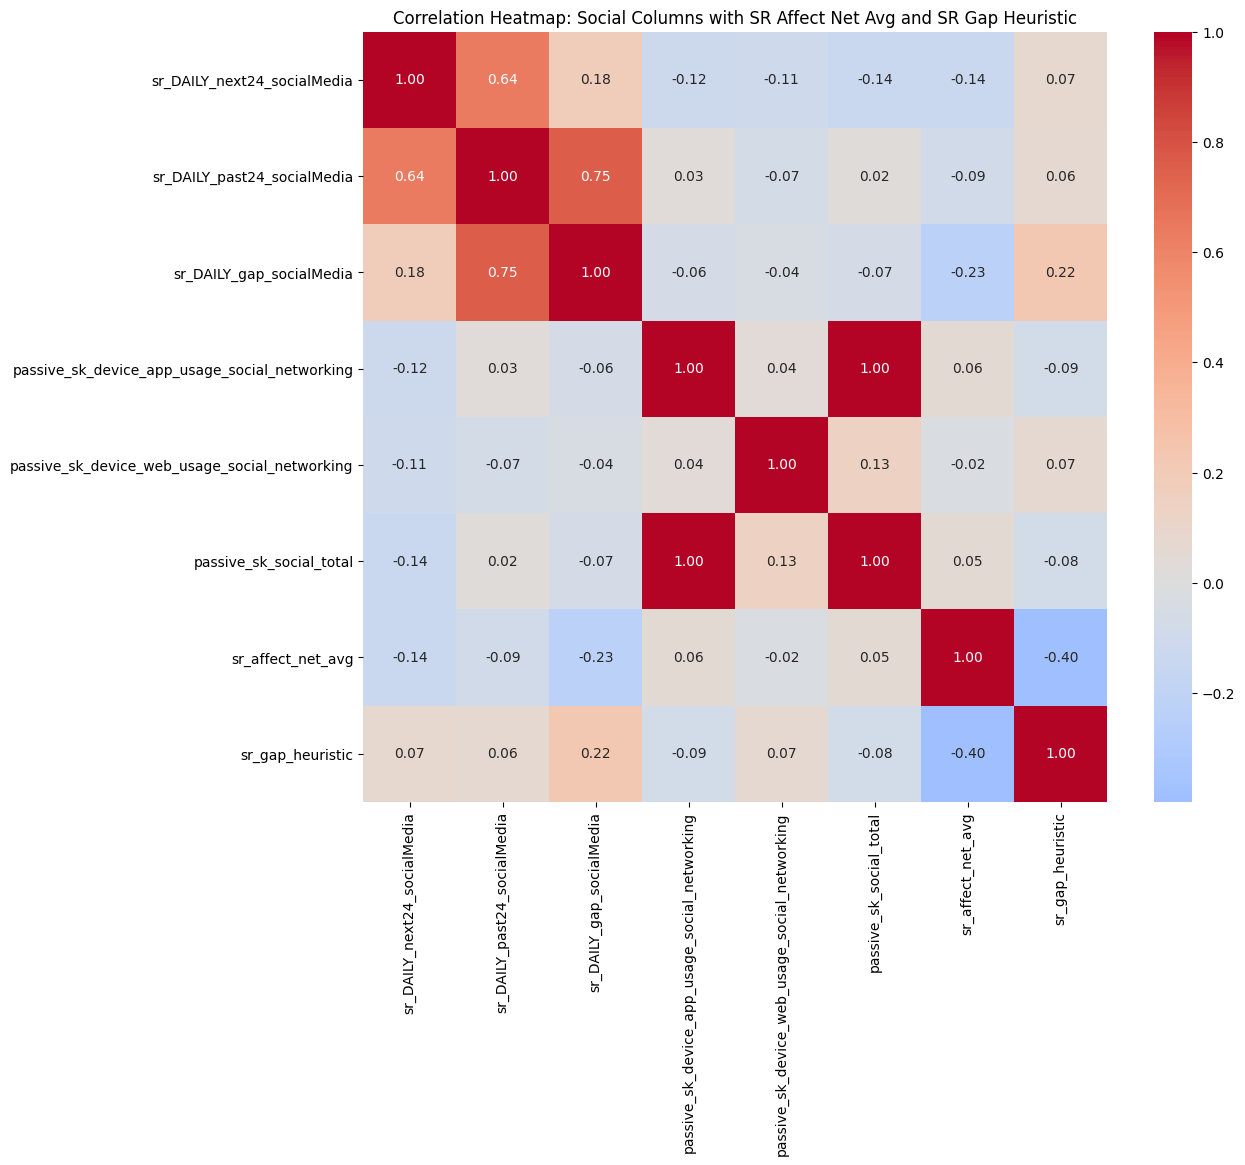

In [41]:
# Find all columns that contain the word "social" in their names in the new dataset
social_columns_new = [col for col in df.columns if 'social' in col.lower()]

# Create a list of columns for the correlation calculation including 'social' columns and the specified columns
columns_for_correlation_new = social_columns_new + ['sr_affect_net_avg', 'sr_gap_heuristic']

# Calculate the correlation matrix for the selected columns in the new dataset
correlation_matrix_new = df[columns_for_correlation_new].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_new, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Heatmap: Social Columns with SR Affect Net Avg and SR Gap Heuristic')
plt.show()

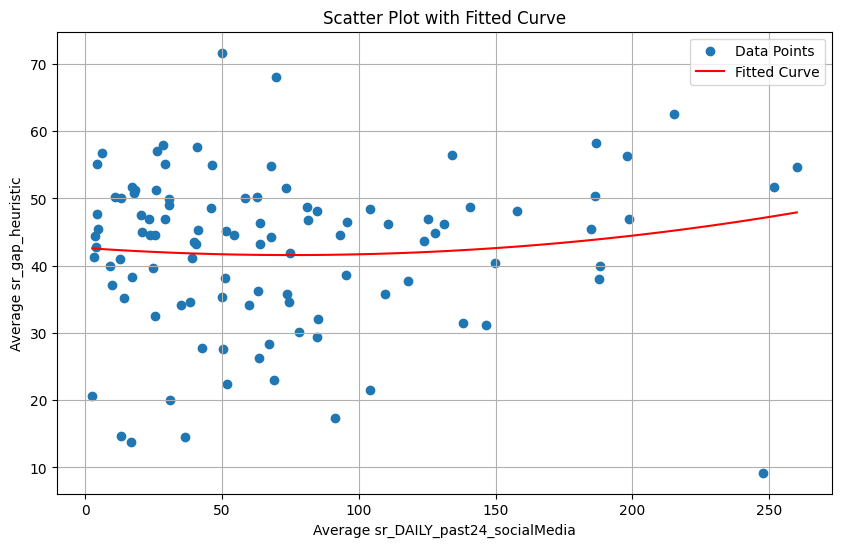

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Calculate the average 'sr_DAILY_past24_socialMedia' and 'sr_gap_heuristic' for each 'PID'
avg_values = df.groupby('PID')[['sr_DAILY_past24_socialMedia', 'sr_gap_heuristic']].mean().reset_index()

# Define a function for curve fitting (quadratic in this case)
def func(x, a, b, c):
    return a * x**2 + b * x + c

# Curve fitting
xdata = avg_values['sr_DAILY_past24_socialMedia']
ydata = avg_values['sr_gap_heuristic']
popt, pcov = curve_fit(func, xdata, ydata)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(xdata, ydata, label='Data Points')
x_line = np.linspace(min(xdata), max(xdata), 100)
plt.plot(x_line, func(x_line, *popt), 'r-', label='Fitted Curve')

plt.title('Scatter Plot with Fitted Curve')
plt.xlabel('Average sr_DAILY_past24_socialMedia')
plt.ylabel('Average sr_gap_heuristic')
plt.legend()
plt.grid(True)
plt.show()


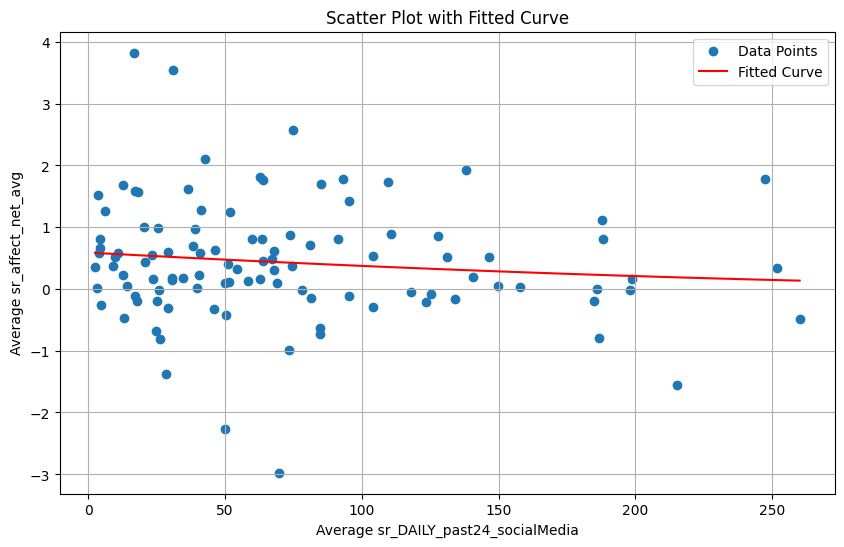

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Calculate the average 'sr_DAILY_past24_socialMedia' and 'sr_affect_net_avg' for each 'PID'
avg_values = df.groupby('PID')[['sr_DAILY_past24_socialMedia', 'sr_affect_net_avg']].mean().reset_index()

# Define a function for curve fitting (quadratic in this case)
def func(x, a, b, c):
    return a * x**2 + b * x + c

# Curve fitting
xdata = avg_values['sr_DAILY_past24_socialMedia']
ydata = avg_values['sr_affect_net_avg']
popt, pcov = curve_fit(func, xdata, ydata)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(xdata, ydata, label='Data Points')
x_line = np.linspace(min(xdata), max(xdata), 100)
plt.plot(x_line, func(x_line, *popt), 'r-', label='Fitted Curve')

plt.title('Scatter Plot with Fitted Curve')
plt.xlabel('Average sr_DAILY_past24_socialMedia')
plt.ylabel('Average sr_affect_net_avg')
plt.legend()
plt.grid(True)
plt.show()


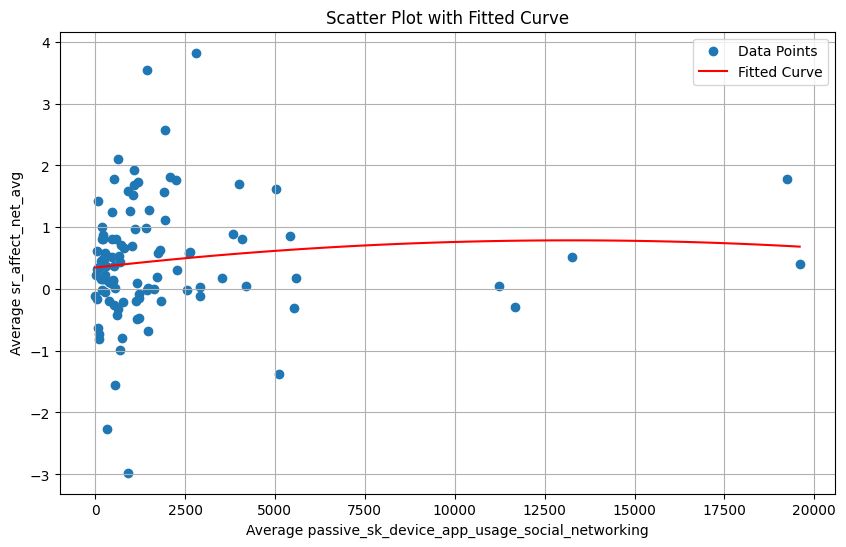

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Calculate the average 'passive_sk_device_app_usage_social_networking' and 'sr_affect_net_avg' for each 'PID'
avg_values = df.groupby('PID')[['passive_sk_device_app_usage_social_networking', 'sr_affect_net_avg']].mean().reset_index()

# Define a function for curve fitting (quadratic in this case)
def func(x, a, b, c):
    return a * x**2 + b * x + c

# Curve fitting
xdata = avg_values['passive_sk_device_app_usage_social_networking']
ydata = avg_values['sr_affect_net_avg']
popt, pcov = curve_fit(func, xdata, ydata)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(xdata, ydata, label='Data Points')
x_line = np.linspace(min(xdata), max(xdata), 100)
plt.plot(x_line, func(x_line, *popt), 'r-', label='Fitted Curve')

plt.title('Scatter Plot with Fitted Curve')
plt.xlabel('Average passive_sk_device_app_usage_social_networking')
plt.ylabel('Average sr_affect_net_avg')
plt.legend()
plt.grid(True)
plt.show()


In [58]:
# Calculate the Pearson correlation coefficient between 'sr_DAILY_past24_socialMedia' and 'sr_gap_heuristic' for each PID
correlations = df.groupby('PID').apply(
    lambda x: x[['sr_DAILY_past24_socialMedia', 'sr_gap_heuristic']].corr().iloc[0, 1]
).reset_index().rename(columns={0: 'Correlation'})

correlations = correlations.sort_values('Correlation', ascending=False)
correlations.head()

,PID,Correlation
56,739d41bb-f3ec-4860-be5a-c711aaec4729,0.494422
44,5af5c134-5a74-416b-b6b2-4e5a29f55688,0.472798
99,f8f71506-9382-40c7-99db-5c170b2a9abb,0.429706
58,76acef3c-d659-4fdd-b258-3668a1597584,0.391726
47,63f4637d-9f05-4561-8995-667470be3c7c,0.374014


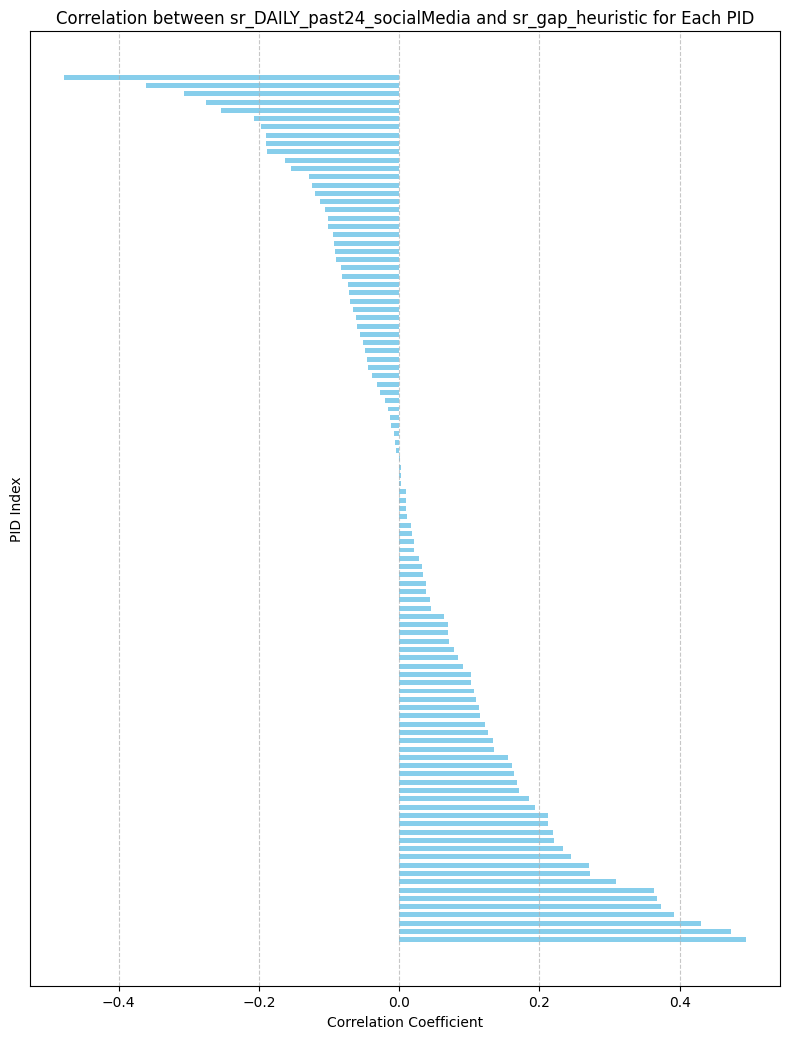

In [57]:
# Adjusting the figure size for the bar plot based on the number of items
fig_height = max(6, len(correlations) * 0.1)
plt.figure(figsize=(8, fig_height))

# Creating vertical bars without PID labels, making bars skinnier
plt.barh(range(len(correlations)), correlations['Correlation'], color='skyblue', height=0.6)


# Setting labels and title
plt.title('Correlation between sr_DAILY_past24_socialMedia and sr_gap_heuristic for Each PID')
plt.xlabel('Correlation Coefficient')
plt.ylabel('PID Index')

# Enhancing layout
plt.yticks([])  # Hide the y-axis labels to keep the plot clean
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [60]:
# Calculate the Pearson correlation coefficient between 'sr_DAILY_past24_socialMedia' and 'sr_gap_heuristic' for each PID
correlations = df.groupby('PID').apply(
    lambda x: x[['sr_DAILY_past24_socialMedia', 'sr_affect_net_avg']].corr().iloc[0, 1]
).reset_index().rename(columns={0: 'Correlation'})

correlations = correlations.sort_values('Correlation', ascending=False)
correlations.head()

,PID,Correlation
1,02f48bee-6e86-437c-9394-10ae57dadd14,0.616977
13,147400db-43d9-4155-8bf2-b85b8adf4315,0.481998
7,08e76051-ee6e-4872-896f-4ed3857afc0f,0.465710
35,4965aa0d-a7a9-4d1c-b835-3f79a29e0d39,0.372387
50,66242a73-d777-49fa-9e11-566005a97f3a,0.346788


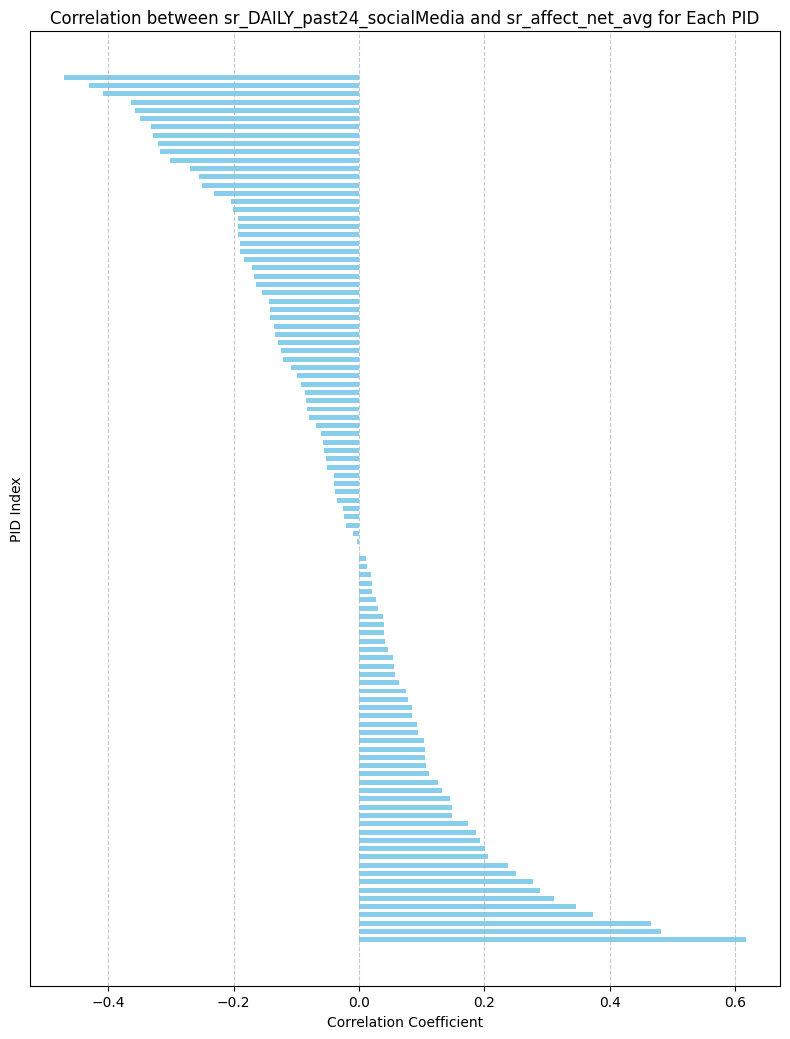

In [61]:
# Adjusting the figure size for the bar plot based on the number of items
fig_height = max(6, len(correlations) * 0.1)
plt.figure(figsize=(8, fig_height))

# Creating vertical bars without PID labels, making bars skinnier
plt.barh(range(len(correlations)), correlations['Correlation'], color='skyblue', height=0.6)


# Setting labels and title
plt.title('Correlation between sr_DAILY_past24_socialMedia and sr_affect_net_avg for Each PID')
plt.xlabel('Correlation Coefficient')
plt.ylabel('PID Index')

# Enhancing layout
plt.yticks([])  # Hide the y-axis labels to keep the plot clean
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
